# Ensemble-Averaging pMDI Spray Images

This program reads output of Step1 and ensemble-averages the extinction data for replicates of the same experiment with the same camera settings.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 08/11/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [1]:
import h5py, os, time, glob
import numpy as np

from scipy.signal import correlate2d
from scipy.fft import fft2, ifft2
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib widget

## Read all the data

In [2]:

prefix = '/Volumes/DUKE SSD ext4 2/2025_Oct_ConeAnglePlaceboStudy/90 & 120 degree/20kHz_896x920_134a_0.3Or08L_cone901.3Dep_MK6/'
wildcard_search = prefix+'20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S*/*.h5'
micron_per_pixel=31.

In [3]:
# Open all the files and get a handle to the relevant data in each.
# This will leave a lot of files open that ought to be properly closed later!
H=[]
data=[]
sprayTiming=[]
for filename in glob.glob(wildcard_search):
    print("Reading %s" % os.path.basename(filename))
    H.append(h5py.File(filename,'r'))
    if not 'bkgnd_removed_images' in H[-1]:
        raise IOError("\tstep 1 output is missing from file.")
    else:
        data.append(H[-1]['bkgnd_removed_images'])

    if not 'spray_morphology' in H[-1]:
        raise IOError("\tstep 3 output is missing from file.")
    else:
        sprayTiming.append((H[-1]['spray_morphology'].attrs['t0'], (H[-1]['spray_morphology'].attrs['t1'])))

Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0002.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0003.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0004.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0005.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0006.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0007.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0008.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0009.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0010.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0011.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0012.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0013.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0014.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0015.h5
Reading 20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0016.h5
Reading 

## Check for nozzle alignment variation

In [4]:
def fft_correlate2d(image, kernel):
    image_fft = fft2(image)
    kernel_fft = fft2(kernel, s=image.shape) # Pad kernel to match image size
    correlation_fft = image_fft * np.conj(kernel_fft)
    return ifft2(correlation_fft).real

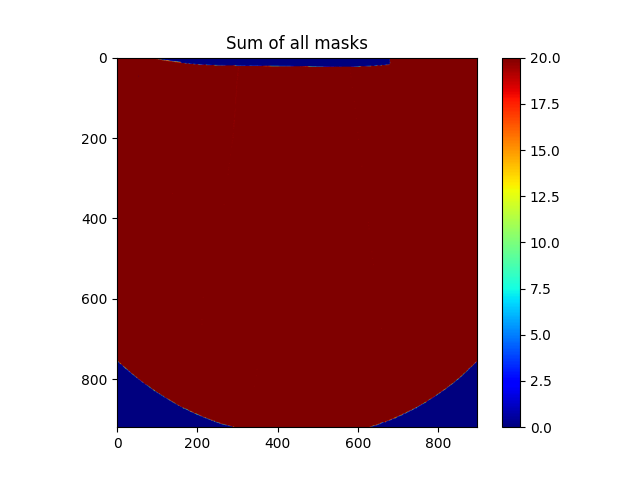

In [5]:
field=np.zeros_like(data[0]['nozzle_mask'],dtype=np.uint8)
prev_mask = field[...]
for i in range(len(data)):
    mask = data[i]['nozzle_mask'][...].astype(np.uint8)
    field += mask

    if i>0:
        cc=fft_correlate2d(mask,prev_mask)
        dx = np.where(cc==np.nanmax(cc))
        if (np.abs(dx[0][0])>1) | (np.abs(dx[1][0])>1):
            raise RuntimeError("Unhandled mask offset detected >1px : %s" % dx)
    prev_mask=mask[...]

fig=plt.figure()
p=plt.imshow(field,cmap='jet')
plt.colorbar(p);
plt.title("Sum of all masks");

## Compute ensemble statistics

In [6]:
def computeStatistics(sprayTiming_, data_, i=0):
    t0,t1=sprayTiming_
    print(" (%i) read & process t=%i-%i frames" % (i,t0,t1))
    filteredData = data_['Iproc'][t0:t1,...]
    #print("\tcomputing stats")
    filteredTemporalAverage = np.nanmean(filteredData,axis=0)
    filteredTemporalStd = np.nanstd(filteredData,axis=0)

    return filteredTemporalAverage, filteredTemporalStd

In [ ]:
# Run parallel multithreaded calculation (limit threads due to RAM requirement).
results = Parallel(n_jobs=4,verbose=10,prefer="threads")(delayed(computeStatistics)(sprayTiming[i],data[i],i) for i in range(len(data)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


(0) read & process t=1494-2935 frames(1) read & process t=1632-2451 frames
(2) read & process t=1703-2329 frames

(3) read & process t=3991-4497 frames
(4) read & process t=4158-4538 frames
(5) read & process t=3063-4208 frames
(6) read & process t=1991-2579 frames
(7) read & process t=2647-4024 frames
(8) read & process t=3849-4222 frames


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  5.8min


(9) read & process t=1303-1913 frames


In [ ]:
print("Computing final ensemble statistics from N=%i replicates" % (len(result)))
ensemble_mean = np.nanmean([result[0] for result in results],axis=0)
temporal_std  = np.nanmean([result[1] for result in results],axis=0)
repeatability = np.nanstd([result[0] for result in results],axis=0)

## Plots

In [ ]:
# Plot everything to check it

for result in results:

    filteredTemporalAverage, filteredTemporalStd = result
    
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(121)
    plt.title("Temporal average")
    p=ax.imshow(filteredTemporalAverage,vmin=0,vmax=0.05)
    plt.colorbar(p)
    ax=fig.add_subplot(122)
    plt.title("Temporal std. dev.")
    p=ax.imshow(filteredTemporalStd,vmin=0,vmax=0.05)
    plt.colorbar(p);
    plt.suptitle("Realization %i" % i)

In [ ]:
# Plot final statistics
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(131)
p=ax.imshow(ensemble_mean,vmin=0,vmax=0.05)
plt.colorbar(p)
plt.title("Ensemble Mean");

ax=fig.add_subplot(132)
p=ax.imshow(temporal_std,vmin=0,vmax=0.05)
plt.colorbar(p)
plt.title("Temporal stability (ensemble avg. of temporal std. dev.)");

ax=fig.add_subplot(133)
p=ax.imshow(repeatability,vmin=0,vmax=0.05)
plt.colorbar(p)
plt.title("Shot-to-shot repeatability (ensemble std. dev. of temporal avg.)");


In [18]:
# Close out all files.
for H_ in H: H_.close()